In [1]:
import os
import json

import cv2
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D,Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback,ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
train_df=pd.read_csv('../../input/train.csv')
train_df['ImageId']=train_df['ImageId_ClassId'].apply(lambda x:x.split('_')[0])
train_df['ClassId']=train_df['ImageId_ClassId'].apply(lambda x:x.split('_')[1])
train_df['hasMask']=~train_df['EncodedPixels'].isna()

print(train_df.shape)
train_df.head()

(50272, 5)


,ImageId_ClassId,EncodedPixels,ImageId,ClassId,hasMask
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1,True
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg,2,False
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg,3,False
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg,4,False
4,00031f466.jpg_1,NaN,00031f466.jpg,1,False


In [3]:
mask_count_df=train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask',ascending=False,inplace=True)
print(mask_count_df.shape)
mask_count_df.head()

(12568, 2)


,ImageId,hasMask
10803,db4867ee8.jpg,3.0
11776,ef24da2ba.jpg,3.0
6284,7f30b9c64.jpg,2.0
9421,bf0c81db6.jpg,2.0
9615,c314f43f3.jpg,2.0


In [4]:
sub_df=pd.read_csv('../../input/sample_submission.csv')
sub_df['ImageId']=sub_df['ImageId_ClassId'].apply(lambda x:x.split('_')[0])
test_imgs=pd.DataFrame(sub_df['ImageId'].unique(),columns=['ImageId'])

In [5]:
def mask2rle(img):
    pixels=img.T.flatten()
    pixels=np.concatenate([[0],pixels,[0]])
    runs=np.where(pixels[1:] != pixels[:-1])[0]+1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
    
def rle2mask(mask_rle,shape=(256,1600)):
    s=mask_rle.split()
    starts,lengths=[np.asarray(x,dtype=int) for x in (s[0:][::2],s[1:][::2])]
    starts -= 1
    ends=starts+lengths
    img=np.zeros(shape[0]*shape[1],dtype=np.uint8)
    for lo,hi in zip(starts,ends):
        img[lo:hi]=1
    return img.reshape(shape,order='F')

In [6]:
def build_masks(rles,input_shape):
    depth=len(rles)
    height,width=input_shape
    masks=np.zeros((height,width,depth))
    
    for i,rle in enumerate(rles):
        if type(rle) is str:
            masks[:,:,i]=rle2mask(rle,(height,width))
            
    return masks

def build_rles(masks):
    width,height,depth=masks.shape
    rles=[mask2rle(masks[:,:,i]) for i in range(depth)]
    
    return rles

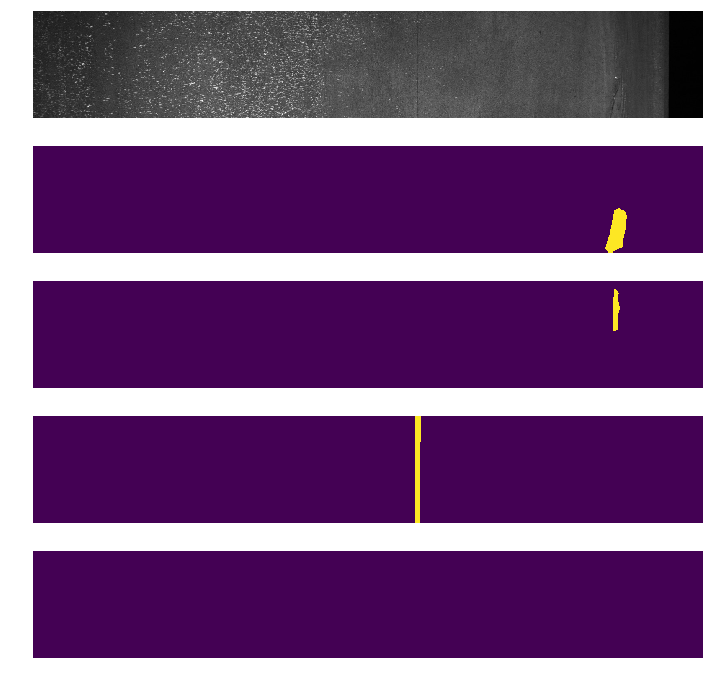

In [7]:
sample_filename='db4867ee8.jpg'
sample_image_df=train_df[train_df['ImageId']==sample_filename]
sample_path=f"../../input/train_images/{sample_image_df['ImageId'].iloc[0]}"
sample_img=cv2.imread(sample_path)
sample_rles=sample_image_df['EncodedPixels'].values
sample_masks=build_masks(sample_rles,input_shape=(256,1600))

fig,axs=plt.subplots(5,figsize=(12,12))
axs[0].imshow(sample_img)
axs[0].axis('off')

for i in range(4):
    axs[i+1].imshow(sample_masks[:,:,i])
    axs[i+1].axis('off')

In [19]:
def dice_coef(y_true,y_pred,smooth=1):
    y_true_f=K.flatten(y_true)
    y_pred_f=K.flatten(y_pred)
    intersection=K.sum(y_true_f*y_pred_f)
    return (2.*intersection+smooth)/(K.sum(y_true_f)+K.sum(y_pred_f)+smooth)

def dice_loss(y_true,y_pred):
    smooth=1.
    y_true_f=K.flatten(y_true)
    y_pred_f=K.flatten(y_pred)
    intersection=y_true_f*y_pred_f
    score=(2*K.sum(intersection)+smooth)/(K.sum(y_true_f)+K.sum(y_pred_f)+smooth)
    return 1. - score

def bce_dice_loss(y_true,y_pred):
    return binary_crossentropy(y_true,y_pred)+dice_loss(y_true,y_pred)

In [9]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self,list_IDs,df,target_df=None,mode='fit',
                base_path='../../input/train_images',batch_size=32,
                dim=(256,1600),n_channels=1,n_classes=4,random_state=2019,
                shuffle=True):
        self.dim=dim
        self.batch_size=batch_size
        self.df=df
        self.mode=mode
        self.base_path=base_path
        self.target_df=target_df
        self.list_IDs=list_IDs
        self.n_channels=n_channels
        self.n_classes=n_classes
        self.shuffle=shuffle
        self.random_state=random_state
        
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.list_IDs)/self.batch_size))
    
    def __getitem__(self,index):
        indexes=self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_batch=[self.list_IDs[k] for k in indexes]
        
        X=self.__generate_X(list_IDs_batch)
        
        if self.mode=='fit':
            y=self.__generate_y(list_IDs_batch)
            return X,y
        
        elif self.mode=='predict':
            return X
        
        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
            
    def on_epoch_end(self):
        self.indexes=np.arange(len(self.list_IDs))
        if self.shuffle==True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
            
    def __generate_X(self,list_IDs_batch):
        X=np.empty((self.batch_size,*self.dim,self.n_channels))
        
        for i,ID in enumerate(list_IDs_batch):
            im_name=self.df['ImageId'].iloc[ID]
            img_path=f"{self.base_path}/{im_name}"
            img=self.__load_grayscale(img_path)
            X[i,]=img
        
        return X
        
    def __generate_y(self,list_IDs_batch):
        y=np.empty((self.batch_size,*self.dim,self.n_classes),dtype=int)
        
        for i,ID in enumerate(list_IDs_batch):
            im_name=self.df['ImageId'].iloc[ID]
            image_df=self.target_df[self.target_df['ImageId']==im_name]
            rles=image_df['EncodedPixels'].values
            masks=build_masks(rles,input_shape=self.dim)
            
            y[i,]=masks
            
        return y
        
    def __load_grayscale(self,img_path):
        img=cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
        img=img.astype(np.float32)/255
        img=np.expand_dims(img,axis=-1)
        
        return img
    
    def __load_rgb(self,img_path):
        img=cv2.imread(img_path)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img=img.astype(np.float32)/255.
        
        return img

In [10]:
BATCH_SIZE=16

train_idx,val_idx=train_test_split(mask_count_df.index,random_state=2019,test_size=0.15)

train_generator=DataGenerator(train_idx,df=mask_count_df,
                             target_df=train_df,batch_size=BATCH_SIZE,
                             n_classes=4)
val_generator=DataGenerator(val_idx,df=mask_count_df,
                           target_df=train_df,batch_size=BATCH_SIZE,
                           n_classes=4)

In [21]:
def build_model(input_shape):
    inputs=Input(input_shape)
    
    c1=Conv2D(8,(3,3),activation='elu',padding='same')(inputs)
    c1=Conv2D(8,(3,3),activation='elu',padding='same')(c1)
    p1=MaxPooling2D((2,2))(c1)
    
    c2=Conv2D(16,(3,3),activation='elu',padding='same')(p1)
    c2=Conv2D(16,(3,3),activation='elu',padding='same')(c2)
    p2=MaxPooling2D((2,2))(c2)
    
    c3=Conv2D(32,(3,3),activation='elu',padding='same')(p2)
    c3=Conv2D(32,(3,3),activation='elu',padding='same')(c3)
    p3=MaxPooling2D((2,2))(c3)
    
    c4=Conv2D(64,(3,3),activation='elu',padding='same')(p3)
    c4=Conv2D(64,(3,3),activation='elu',padding='same')(c4)
    p4=MaxPooling2D((2,2))(c4)
    
    c5=Conv2D(128,(3,3),activation='elu',padding='same')(p4)
    c5=Conv2D(128,(3,3),activation='elu',padding='same')(c5)
    
    u6=Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c5)
    u6=concatenate([u6,c4])
    c6=Conv2D(64,(3,3),activation='elu',padding='same')(u6)
    c6=Conv2D(64,(3,3),activation='elu',padding='same')(c6)
    
    u7=Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c6)
    u7=concatenate([u7,c3])
    c7=Conv2D(32,(3,3),activation='elu',padding='same')(u7)
    c7=Conv2D(32,(3,3),activation='elu',padding='same')(c7)
    
    u8=Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c7)
    u8=concatenate([u8,c2])
    c8=Conv2D(16,(3,3),activation='elu',padding='same')(u8)
    c8=Conv2D(16,(3,3),activation='elu',padding='same')(c8)
    
    u9=Conv2DTranspose(8,(2,2),strides=(2,2),padding='same')(c8)
    u9=concatenate([u9,c1])
    c9=Conv2D(8,(3,3),activation='elu',padding='same')(u9)
    c9=Conv2D(8,(3,3),activation='elu',padding='same')(c9)
    
    outputs=Conv2D(4,(1,1),activation='sigmoid')(c9)
    
    model=Model(inputs=[inputs],outputs=[outputs])
    model.compile(optimizer='Nadam',loss=bce_dice_loss,metrics=[dice_coef])
    
    return model

In [22]:
model=build_model((256,1600,1))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 256, 1600, 1) 0                                            
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 256, 1600, 8) 80          input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 256, 1600, 8) 584         conv2d_72[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_18 (MaxPooling2D) (None, 128, 800, 8)  0           conv2d_73[0][0]                  
__________________________________________________________________________________________________
conv2d_74 

In [24]:
checkpoint=ModelCheckpoint('../../output/model_unet.h5',
                          monitor='val_dice_coef',
                          verbose=0,
                          save_best_only=True,
                          save_weights_only=False,
                          mode='auto')

history=model.fit_generator(train_generator,
                           validation_data=val_generator,
                           callbacks=[checkpoint],
                           use_multiprocessing=False,
                           workers=1,
                           epochs=7)

W0921 15:51:24.845451 139831969502976 deprecation_wrapper.py:119] From /home/tyonetrap/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/7
668/668 [==============================] - 920s 1s/step - loss: 1.0575 - dice_coef: 0.0263 - val_loss: 1.0073 - val_dice_coef: 0.0367
Epoch 2/7
668/668 [==============================] - 858s 1s/step - loss: 0.9838 - dice_coef: 0.0679 - val_loss: 0.9212 - val_dice_coef: 0.1266
Epoch 3/7
668/668 [==============================] - 859s 1s/step - loss: 0.8605 - dice_coef: 0.1948 - val_loss: 0.8473 - val_dice_coef: 0.2022
Epoch 4/7
668/668 [==============================] - 834s 1s/step - loss: 1.1122 - dice_coef: 0.0132 - val_loss: 1.1225 - val_dice_coef: 7.0523e-06
Epoch 5/7
668/668 [==============================] - 832s 1s/step - loss: 1.1289 - dice_coef: 6.9083e-06 - val_loss: 1.1225 - val_dice_coef: 7.0505e-06
Epoch 6/7
668/668 [==============================] - 833s 1s/step - loss: 1.1289 - dice_coef: 6.9094e-06 - val_loss: 1.1225 - val_dice_coef: 7.0540e-06
Epoch 7/7
668/668 [==============================] - 833s 1s/step - loss: 1.1289 - dice_coef: 6.9162e-06 - val_loss:

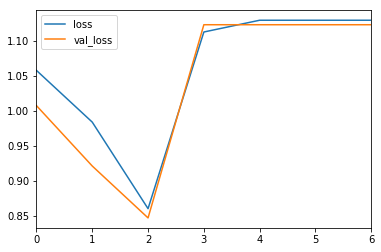

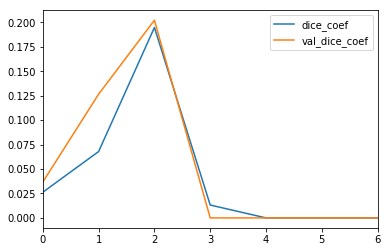

In [25]:
with open('history.json','w') as f:
    json.dump(history.history,f)
    
history_df=pd.DataFrame(history.history)
history_df[['loss','val_loss']].plot()
history_df[['dice_coef','val_dice_coef']].plot()

In [46]:
model.load_weights('../../output/model_unet.h5')
test_df=[]

for i in range(0,test_imgs.shape[0],500):
    batch_idx=list(range(i,min(test_imgs.shape[0],i+500)))
    
    test_generator=DataGenerator(batch_idx,df=test_imgs,
                                shuffle=False,mode='predict',
                                base_path='../../input/test_images',
                                target_df=sub_df,batch_size=1,
                                n_classes=4)
    
    batch_pred_masks=model.predict_generator(test_generator,
                                            workers=1,
                                            verbose=1,use_multiprocessing=False)
    
    for j,b in tqdm(enumerate(batch_idx)):
        filename=test_imgs['ImageId'].iloc[b]
        image_df=sub_df[sub_df['ImageId']==filename].copy()
        pred_masks=batch_pred_masks[j, ].round().astype(int)
        pred_rles=build_rles(pred_masks)
        
        image_df['EncodedPixels']=pred_rles
        test_df.append(image_df)
        
    

500/500 [==============================] - 13s 27ms/step


500it [00:05, 89.64it/s]

  1/500 [..............................] - ETA: 20s

500/500 [==============================] - 13s 26ms/step


500it [00:05, 91.75it/s]


500/500 [==============================] - 13s 26ms/step


500it [00:05, 90.09it/s]

  1/301 [..............................] - ETA: 8s

301/301 [==============================] - 8s 26ms/step


301it [00:03, 90.16it/s]


In [48]:
test_df=pd.concat(test_df)
test_df.drop(columns='ImageId',inplace=True)

In [ ]:
test_df['EncodedPixels'].values